# Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations

>  In this first part, we demonstrate how these networks can be used to infer solutions to partial differential equations, and obtain physics-informed surrogate models that are fully differentiable with respect to all input coordinates and free parameters.

In the paper, the authors explore equations of the form : 
$$u_t + \mathcal{N}[u;\lambda] = 0$$
where $u(t,x)$ is the latent (hidden) solution and $\mathcal{N}[\cdot;\lambda]$ is a nonlinear operator parametrized by $\lambda$. 

We explore the 1D Burgers' equation : 
$$u_t + \lambda_1 u u_x - \lambda_2 u_{xx} = 0$$ 
along with Dirichlet boundary conditions :
$$\begin{align*}
u_t + u u_x - \dfrac{0.01}{\pi} u_{xx} &= 0,\quad x \in [-1, 1], t \in [0, 1]\\
u(0, x) &= - sin(\pi x)\\
u(t, -1) &= u(t, 1) = 0 
\end{align*}$$

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 14
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
class BurgersEquation1D:
    def __init__(self, lambda_1, lambda_2):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2

    #should return the residual of the PDE
    def __call__(self, u, x, t):
        torch.autograd.set_detect_anomaly(True)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        return u_t + self.lambda_1 * u * u_x - self.lambda_2 * u_xx


class PhysicsInformedNeuralNetwork(nn.Module):
    def __init__(self, equation, solver):
        super(PhysicsInformedNeuralNetwork, self).__init__()
        self.equation = equation
        self.solver = solver

    def forward(self, x, t):
        #require grad
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        u = self.solver(x, t)
        residual = self.equation(u, x, t)
        return u, residual
    
# u_pred and u_target are the initial and boundary conditions
# residual is the residual of the PDE at the collocation points
# usually N_u is small and that's why we want to use a PINN to enrich the data information content
def loss_fn(u_pred, u_target, residual):
    return torch.mean((u_pred - u_target)**2) + torch.mean(residual**2)

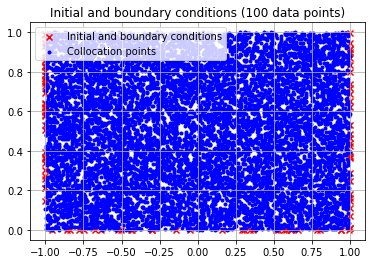

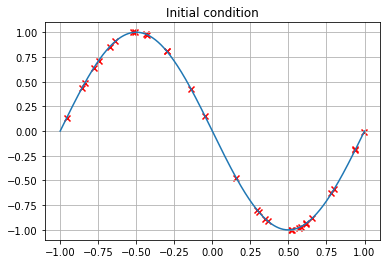

In [3]:
N_u = 100
N_f = 10000
x_space_range = [-1, 1]
t_space_range = [0, 1]

#initial condition
def u_0(x):
    return -torch.sin(np.pi * x)

#boundary condition
def u_L(t):
    return torch.zeros_like(t)

def u_R(t):
    return torch.zeros_like(t)

def generate_data_points(N_u, N_f, x_space_range, t_space_range):
    left_x = torch.tensor([x_space_range[0]]).repeat(N_u, 1)
    left_t = torch.rand(N_u, 1) * (t_space_range[1] - t_space_range[0]) + t_space_range[0]
    left = torch.cat((left_x, left_t), 1)
    left_u = u_L(left_x)

    right_x = torch.tensor([x_space_range[1]]).repeat(N_u, 1)
    right_t = torch.rand(N_u, 1) * (t_space_range[1] - t_space_range[0]) + t_space_range[0]
    right = torch.cat((right_x, right_t), 1)
    right_u = u_R(right_x)

    initial_x = torch.rand(N_u, 1) * (x_space_range[1] - x_space_range[0]) + x_space_range[0]
    initial_t = torch.zeros(N_u, 1)
    initial = torch.cat((initial_x, initial_t), 1)
    initial_u = u_0(initial_x)

    left_points = torch.cat((left, left_u), 1)
    right_points = torch.cat((right, right_u), 1)
    initial_points = torch.cat((initial, initial_u), 1)

    points = torch.cat((left_points, right_points, initial_points), 0)
    #shuffle the points
    points = points[torch.randperm(points.size()[0])]

    x_N_f = torch.rand(N_f, 1) * (x_space_range[1] - x_space_range[0]) + x_space_range[0]
    t_N_f = torch.rand(N_f, 1) * (t_space_range[1] - t_space_range[0]) + t_space_range[0]

    points_N_f = torch.cat((x_N_f, t_N_f), 1)

    return points[:N_u], points_N_f

N_u_points, N_f_points = generate_data_points(N_u, N_f, x_space_range, t_space_range)

#make a plot with crosses for the initial and boundary conditions
plt.title(f'Initial and boundary conditions ({N_u_points.shape[0]} data points)')
plt.scatter(N_u_points[:, 0], N_u_points[:, 1], marker='x', color='red')
plt.scatter(N_f_points[:, 0], N_f_points[:, 1], marker='.', color='blue')
plt.legend(['Initial and boundary conditions', 'Collocation points'])
plt.grid()
plt.show()

# make a plot of the initial condition
x = torch.linspace(x_space_range[0], x_space_range[1], 1000).reshape(-1, 1)
plt.title('Initial condition')
plt.plot(x, u_0(x))
plt.scatter(N_u_points[N_u_points[:, 1] == 0][:, 0], N_u_points[N_u_points[:, 1] == 0][:, 2], marker='x', color='red')
plt.grid()
plt.show()

In [4]:
class SimpleSolver(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(SimpleSolver, self).__init__()
        layers = [nn.Linear(2, n_neurons), nn.Tanh()]
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(n_neurons, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        X = torch.cat((x, t), 1)
        return self.net(X)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

lambda_1 = 1
lambda_2 = 0.01/np.pi

equation = BurgersEquation1D(lambda_1, lambda_2)
n_layers = 9
n_neurons = 20
net = SimpleSolver(n_layers, n_neurons)
print("Number of parameters :", sum(p.numel() for p in net.parameters() if p.requires_grad)) # should be 3021 parameters

pinn = PhysicsInformedNeuralNetwork(equation, net)
pinn.to(device)

cuda
Number of parameters : 3021


PhysicsInformedNeuralNetwork(
  (solver): SimpleSolver(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Tanh()
      (6): Linear(in_features=20, out_features=20, bias=True)
      (7): Tanh()
      (8): Linear(in_features=20, out_features=20, bias=True)
      (9): Tanh()
      (10): Linear(in_features=20, out_features=20, bias=True)
      (11): Tanh()
      (12): Linear(in_features=20, out_features=20, bias=True)
      (13): Tanh()
      (14): Linear(in_features=20, out_features=20, bias=True)
      (15): Tanh()
      (16): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)

Epoch 0 - Loss: 0.21310898661613464
Epoch 100 - Loss: 0.17997421324253082
Epoch 200 - Loss: 0.16510701179504395
Epoch 300 - Loss: 0.1628379374742508
Epoch 400 - Loss: 0.16091789305210114
Epoch 500 - Loss: 0.1583726853132248
Epoch 600 - Loss: 0.15333598852157593
Epoch 700 - Loss: 0.14082646369934082
Epoch 800 - Loss: 0.12939225137233734
Epoch 900 - Loss: 0.11287710070610046
Epoch 1000 - Loss: 0.08680252730846405
Epoch 1100 - Loss: 0.07929670810699463
Epoch 1200 - Loss: 0.07511341571807861
Epoch 1300 - Loss: 0.07148676365613937
Epoch 1400 - Loss: 0.06683546304702759
Epoch 1500 - Loss: 0.06312190741300583
Epoch 1600 - Loss: 0.06092052906751633
Epoch 1700 - Loss: 0.05874428153038025
Epoch 1800 - Loss: 0.05564601719379425
Epoch 1900 - Loss: 0.051730502396821976
Epoch 2000 - Loss: 0.049125343561172485
Epoch 2100 - Loss: 0.047587569802999496
Epoch 2200 - Loss: 0.046309538185596466
Epoch 2300 - Loss: 0.045164138078689575
Epoch 2400 - Loss: 0.04409589618444443
Epoch 2500 - Loss: 0.0430565923452

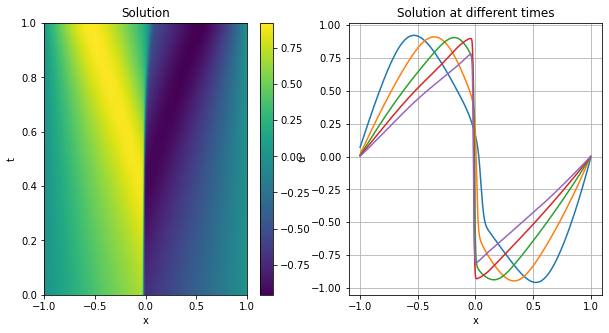

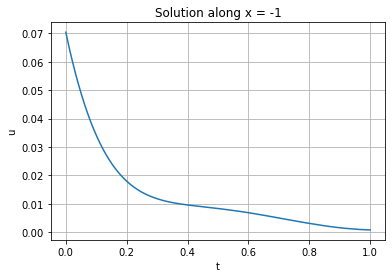

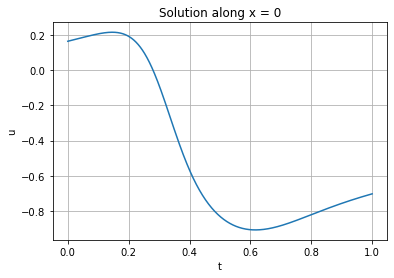

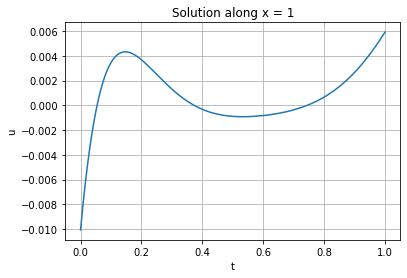

In [5]:
# In the article, they use the L-BFGS optimizer but here I will use the Adam optim.
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
batch_size = N_f

path_to_save = 'burgers_model.pth'

#training loop
n_epochs = 10000

for epoch in range(n_epochs):
    #generate a batch of data
    u_target = N_u_points[:, 2].reshape(-1, 1)
    x_u = N_u_points[:, 0].reshape(-1, 1)
    t_u = N_u_points[:, 1].reshape(-1, 1)

    idx_f = torch.randperm(N_f_points.shape[0])[:batch_size]
    x_f = N_f_points[idx_f, 0].reshape(-1, 1)
    t_f = N_f_points[idx_f, 1].reshape(-1, 1)

    x_u = x_u.to(device)
    t_u = t_u.to(device)
    u_target = u_target.to(device)
    x_f = x_f.to(device)
    t_f = t_f.to(device)

    optimizer.zero_grad()
    u_pred, _ = pinn(x_u, t_u)
    _, residual = pinn(x_f, t_f)
    loss = loss_fn(u_pred, u_target.to(device), residual)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch} - Loss: {loss.item()}')
        torch.save(pinn.state_dict(), path_to_save)
        
        
#plot the solution using numpy and matplotlib cannot use torch
# plot a heatmap of the solution
# plot the solution along x = -1, x = 0, x = 1

res_x = 1000
res_t = 25
x = np.linspace(x_space_range[0], x_space_range[1], res_x)
t = np.linspace(t_space_range[0], t_space_range[1], res_t)
X, T = np.meshgrid(x, t)
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)
X = torch.tensor(X).float()
T = torch.tensor(T).float()

U, _ = pinn(X.to(device), T.to(device))
U = U.cpu().detach().numpy().reshape(res_t, res_x)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(U, aspect='auto', extent=[x_space_range[0], x_space_range[1], t_space_range[0], t_space_range[1]])
plt.colorbar()
plt.title('Solution')
plt.xlabel('x')
plt.ylabel('t')

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(x, U[i*5])
plt.title('Solution at different times')
plt.xlabel('x')
plt.ylabel('u')
plt.grid()
plt.show()

#plot the solution along x = -1, x = 0, x = 1
res = 1000
x = torch.tensor(-1, dtype=torch.float32).reshape(-1, 1).repeat(res, 1)
t = torch.linspace(0, 1, res).reshape(-1, 1)
U, _ = pinn(x.to(device), t.to(device))
U = U.cpu().detach().numpy()

plt.plot(t, U)
plt.title('Solution along x = -1')
plt.xlabel('t')
plt.ylabel('u')
plt.grid()
plt.show()

x = torch.tensor(0, dtype=torch.float32).reshape(-1, 1).repeat(res, 1)
t = torch.linspace(0, 1, res).reshape(-1, 1)
U, _ = pinn(x.to(device), t.to(device))
U = U.cpu().detach().numpy()

plt.plot(t, U)
plt.title('Solution along x = 0')
plt.xlabel('t')
plt.ylabel('u')
plt.grid()
plt.show()

x = torch.tensor(1, dtype=torch.float32).reshape(-1, 1).repeat(res, 1)
t = torch.linspace(0, 1, res).reshape(-1, 1)
U, _ = pinn(x.to(device), t.to(device))
U = U.cpu().detach().numpy()

plt.plot(t, U)
plt.title('Solution along x = 1')
plt.xlabel('t')
plt.ylabel('u')
plt.grid()
plt.show()